# Scattertext spaCy with Yelp Dataset
https://github.com/gyhou/yelp_dataset

https://www.yelp.com/dataset/

Exploratory data analysis and visualization for text data

In [33]:
import pandas as pd

df = pd.read_csv('yelp_reviews_RV_categories.csv')
print(df.shape)
df.head()

(5342, 15)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date
0,q0B39iv1bs16PO--eiMfIw,Hobo Camper Country,4020 Edmonton Trail NE,Calgary,AB,T2E 3P6,51.088523,-114.051507,1.5,NaN,"RV Repair, Auto Repair, Automotive",DLURbx1V0QyJrntcTyMR4w,1,it is todays experience that got HCC (Hobo Cam...,2016-09-06 18:06:23
1,q0B39iv1bs16PO--eiMfIw,Hobo Camper Country,4020 Edmonton Trail NE,Calgary,AB,T2E 3P6,51.088523,-114.051507,1.5,NaN,"RV Repair, Auto Repair, Automotive",0RsS3-oJ_MBJ-Fb9I-oBhA,2,"Meh, needed parts got attitude. went somewher...",2016-08-11 17:56:24
2,q0B39iv1bs16PO--eiMfIw,Hobo Camper Country,4020 Edmonton Trail NE,Calgary,AB,T2E 3P6,51.088523,-114.051507,1.5,NaN,"RV Repair, Auto Repair, Automotive",X_W-pHzDboM1jGz60f81cA,1,My father took his motorhome in to get the Ant...,2016-09-26 02:25:28
3,SW_bePWPlMZJZGQ4eT9vrA,E's RV Appliance Repair,"1959 S Power Rd, Ste 103-238",Mesa,AZ,85206,33.379981,-111.687220,5.0,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Automotive, Water Heater Installation/Repair, ...",pR29E9_ird-h26CY7t18Ag,5,Eric was great! He diagnosed my LQ horse trail...,2018-05-21 15:46:27
4,SW_bePWPlMZJZGQ4eT9vrA,E's RV Appliance Repair,"1959 S Power Rd, Ste 103-238",Mesa,AZ,85206,33.379981,-111.687220,5.0,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Automotive, Water Heater Installation/Repair, ...",KGZGa7Hnx6WiAVqtV_uizQ,5,Always ready to help us whenever we are in tow...,2018-04-29 23:23:56


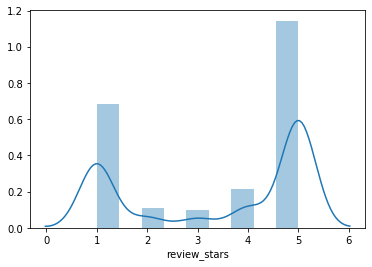

In [34]:
# Check how rating is distributed
import seaborn as sns
sns.distplot(df['review_stars']);

In [35]:
# Consolidate rating to high or low
df['rating'] = df['review_stars'].replace({1:'Low Rating', 2:'Low Rating', 3:'Low Rating',
                                           4:'High Rating', 5:'High Rating'})
df.rating.value_counts()

High Rating    3223
Low Rating     2119
Name: rating, dtype: int64

In [36]:
df_RV_Auto = df[df['categories'].str.contains('RV Repair|RV Dealers|RV Rental', case=False, na=False)]
df_Parks_Camp = df[df['categories'].str.contains('RV Parks|Campgrounds', case=False, na=False)]

## Use NLP on review text

In [ ]:
# Make sure you have the english language model
# small, medium, large all works
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_lg

In [15]:
import spacy
import scattertext

# use the english model that you have
nlp = spacy.load('en_core_web_lg')

In [63]:
# Create a text file to fill stop words
with open('stopwords.txt', 'r') as f:
    str_f = f.read()
    set_stopwords = set(str_f.split('\n'))
nlp.Defaults.stop_words |= set_stopwords

In [64]:
corpus = (scattertext.CorpusFromPandas(df_RV,
                                       category_col='rating', 
                                       text_col='text',
                                       nlp=nlp)
          .build()
          .remove_terms(nlp.Defaults.stop_words, ignore_absences=True)
         )

In [58]:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['High_Rating_Score'] = corpus.get_scaled_f_scores('High Rating')
term_freq_df['Poor_Rating_Score'] = corpus.get_scaled_f_scores('Low Rating')

df_high = term_freq_df.sort_values(by='High Rating freq', 
                                   ascending = False)
df_poor = term_freq_df.sort_values(by='Low Rating freq', 
                                   ascending=False)

df_high['High_Rating_Score'] = round(df_high['High_Rating_Score'], 2)
df_high['Poor_Rating_Score'] = round(df_high['Poor_Rating_Score'], 2)
df_high = df_high.reset_index(drop=False)

df_poor['High_Rating_Score'] = round(df_poor['High_Rating_Score'], 2)
df_poor['Poor_Rating_Score'] = round(df_poor['Poor_Rating_Score'], 2)
df_poor = df_poor.reset_index(drop=False)

In [ ]:
# Make sure we can see all of the columns
pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 200)

In [59]:
df_high_RV = df_high
df_poor_RV = df_poor

In [60]:
df_high_RV.head()

,term,Low Rating freq,High Rating freq,High_Rating_Score,Poor_Rating_Score
0,great,263,1763,0.98,0.02
1,service,1485,1620,0.89,0.11
2,time,1100,1177,0.89,0.11
3,work,755,935,0.90,0.10
4,nice,357,746,0.94,0.06


In [62]:
df_poor_RV.head()

,term,Low Rating freq,High Rating freq,High_Rating_Score,Poor_Rating_Score
0,service,1485,1620,0.89,0.11
1,$,1221,320,0.04,0.96
2,time,1100,1177,0.89,0.11
3,said,1048,237,0.04,0.96
4,called,806,411,0.09,0.91
5,trailer,805,733,0.87,0.13
6,like,757,586,0.13,0.87
7,work,755,935,0.90,0.10
8,day,672,539,0.14,0.86
9,new,636,678,0.89,0.11


## Using Scattertext to visualize term associations

In [65]:
html = scattertext.produce_scattertext_explorer(corpus,
          category='Low Rating',
          category_name='Low Rating',
          not_category_name='High Rating',
          width_in_pixels=1000,
          metadata=df['name'])

C:\Users\George\Anaconda3\lib\site-packages\scattertext\TermDocMatrixWithoutCategories.py:154: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  corpus_unigram_freq = corpus_freq_df.ix[[term for term


In [66]:
open("RV-Yelp-Reviews-Scattertext.html", 'wb').write(html.encode('utf-8'))

5614340